# Ring spot helper demonstration


This notebook demonstrates the analytic ring spot helper using the same mesh API that powers ``add_spot`` and ``add_pulsation``.
We'll build a base ``IcosphereModel``, perturb its temperature and gravity columns with ``add_ring_spot``, and forward the spotted
mesh through the ``PhysicalLineEmulator`` to see how the bright ring reshapes a Ca II IRT-like spectral line.


## Imports and configuration


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from spice.models import IcosphereModel
from spice.models.spots import add_ring_spot, RingSpotConfig
from spice.utils.ring_spot import ring_spot_weights, ca_irt_scale_map
from spice.spectrum import PhysicalLineEmulator

## Build a base mesh and apply ``add_ring_spot``


In [2]:
cfg = RingSpotConfig()
base_temp = 5700.0
base_logg = 4.35

mesh = IcosphereModel.construct(
    2000,
    1.0,
    1.0,
    jnp.array([base_temp, base_logg]),
    ['teff', 'logg']
)

spot_center_theta = jnp.deg2rad(35.0)
spot_center_phi = jnp.deg2rad(55.0)

teff_mesh = add_ring_spot(
    mesh,
    spot_center_theta=spot_center_theta,
    spot_center_phi=spot_center_phi,
    param_index=0,
    config=cfg,
)

spotted_mesh = add_ring_spot(
    teff_mesh,
    spot_center_theta=spot_center_theta,
    spot_center_phi=spot_center_phi,
    param_index=1,
    config=cfg,
    umbra_delta=-0.2,
    plage_delta=0.05,
)

normals = mesh.d_centers / jnp.linalg.norm(mesh.d_centers, axis=1, keepdims=True)
spot_axis = jnp.array([
    jnp.sin(spot_center_theta) * jnp.cos(spot_center_phi),
    jnp.sin(spot_center_theta) * jnp.sin(spot_center_phi),
    jnp.cos(spot_center_theta),
])
w_umb, w_plage = ring_spot_weights(normals, spot_axis, cfg)

normals_np = np.array(normals)
lon = np.degrees(np.arctan2(normals_np[:, 1], normals_np[:, 0]))
lat = np.degrees(np.arcsin(normals_np[:, 2]))

temp_delta = np.array(spotted_mesh.parameters[:, 0] - mesh.parameters[:, 0])
logg_delta = np.array(spotted_mesh.parameters[:, 1] - mesh.parameters[:, 1])


### Umbra and plage weights


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
sc0 = axes[0].scatter(lon, lat, c=np.array(w_umb), s=10, cmap='magma', vmin=0.0)
axes[0].set_title('Umbra weight')
axes[0].set_xlabel('Longitude [deg]')
axes[0].set_ylabel('Latitude [deg]')
fig.colorbar(sc0, ax=axes[0], label='w_umb')

sc1 = axes[1].scatter(lon, lat, c=np.array(w_plage), s=10, cmap='viridis', vmin=0.0)
axes[1].set_title('Plage weight')
axes[1].set_xlabel('Longitude [deg]')
axes[1].set_ylabel('Latitude [deg]')
fig.colorbar(sc1, ax=axes[1], label='w_plage')
plt.show()


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_42682/2928994273.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Parameter perturbations


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
sc0 = axes[0].scatter(lon, lat, c=temp_delta, s=10, cmap='coolwarm')
axes[0].set_title('Temperature perturbation [K]')
axes[0].set_xlabel('Longitude [deg]')
axes[0].set_ylabel('Latitude [deg]')
fig.colorbar(sc0, ax=axes[0], label='ΔT')

sc1 = axes[1].scatter(lon, lat, c=logg_delta, s=10, cmap='Spectral')
axes[1].set_title('log g perturbation [dex]')
axes[1].set_xlabel('Longitude [deg]')
axes[1].set_ylabel('Latitude [deg]')
fig.colorbar(sc1, ax=axes[1], label='Δlog g')
plt.show()


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_42682/2372763797.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Feature-specific scaling map (optional)
Use ``ca_irt_scale_map`` to create a per-element multiplier that you can
apply to any spectral mask after running your favorite emulator.


In [5]:
scale_map = ca_irt_scale_map(normals, spot_axis, cfg, plage_scale=0.6, umbra_scale=-0.4)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].hist(np.array(scale_map), bins=30, color='tab:blue')
axes[0].set_xlabel('Scale factor')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of mask scaling')

sc = axes[1].scatter(lon, lat, c=np.array(scale_map), s=10, cmap='cividis')
axes[1].set_title('Per-element scaling pattern')
axes[1].set_xlabel('Longitude [deg]')
axes[1].set_ylabel('Latitude [deg]')
fig.colorbar(sc, ax=axes[1], label='scale')
plt.show()


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_42682/1828299307.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Disk-integrated ``PhysicalLineEmulator`` example
The same spotted mesh can be pushed through ``PhysicalLineEmulator`` to see how the Ca II 8542 Å line reacts to the bright ring.
Because the plage wraps around an off-axis latitude, it deepens the blue wing when that sector rotates toward the observer, producing a subtle asymmetry in the disk-integrated line.


In [6]:
log_wavelengths = jnp.linspace(jnp.log10(8535.0), jnp.log10(8554.0), 600)
wavelength = np.array(10 ** log_wavelengths)

emulator = PhysicalLineEmulator(
    line_center=8542.09,
    line_depth=0.45,
    atomic_mass=40.078,
    v_micro=2.0,
    gamma0=0.07,
    line_profile_kind='voigt',
    limb_law='quadratic',
    limb_coeffs=(0.3, 0.2),
    use_convective_shift=True,
    v_conv0=1.0,
)


In [9]:
import matplotlib
%matplotlib inline

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>)

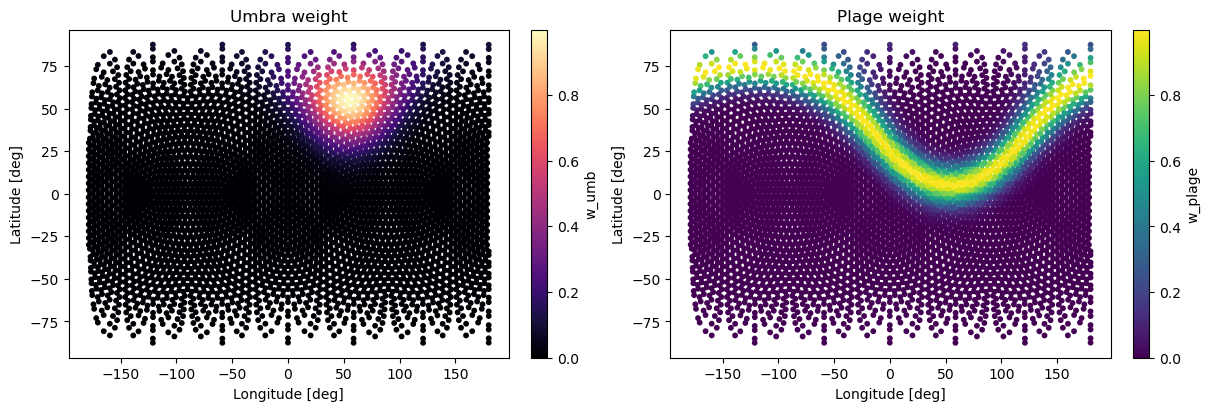

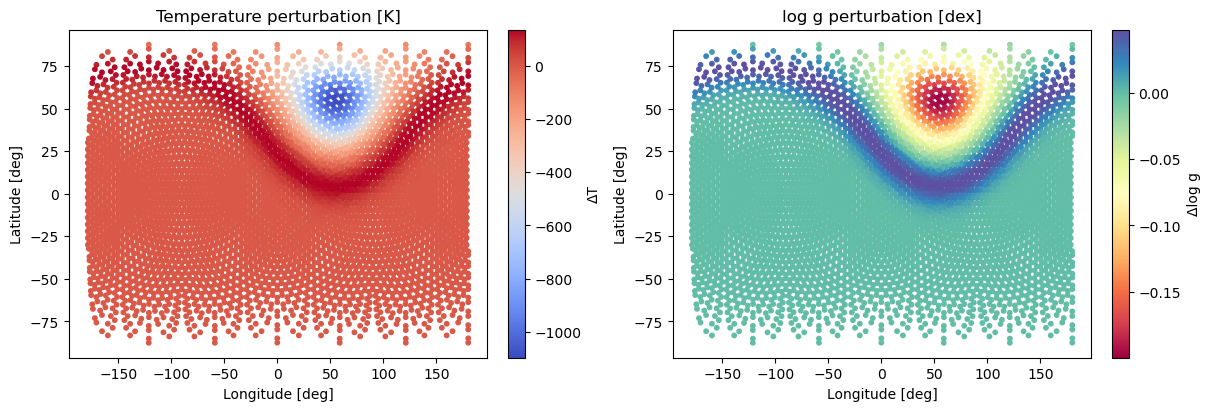

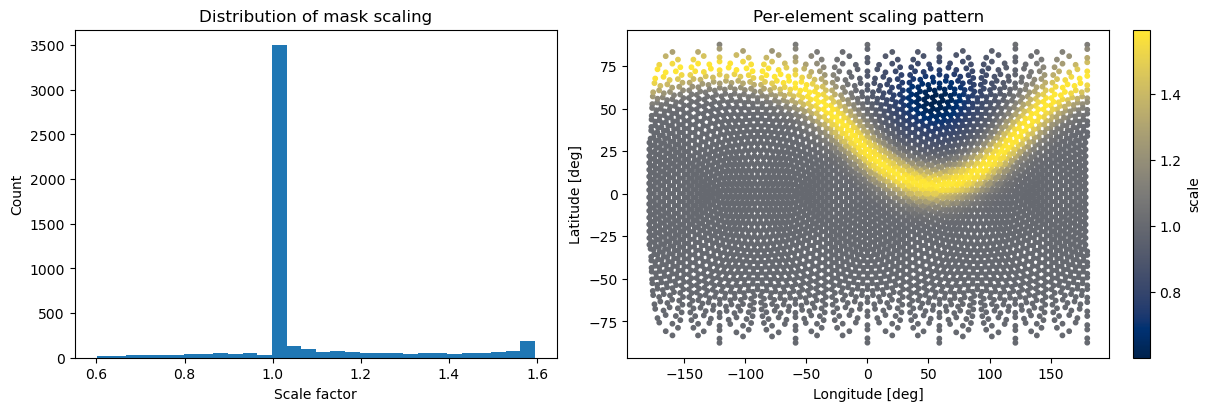

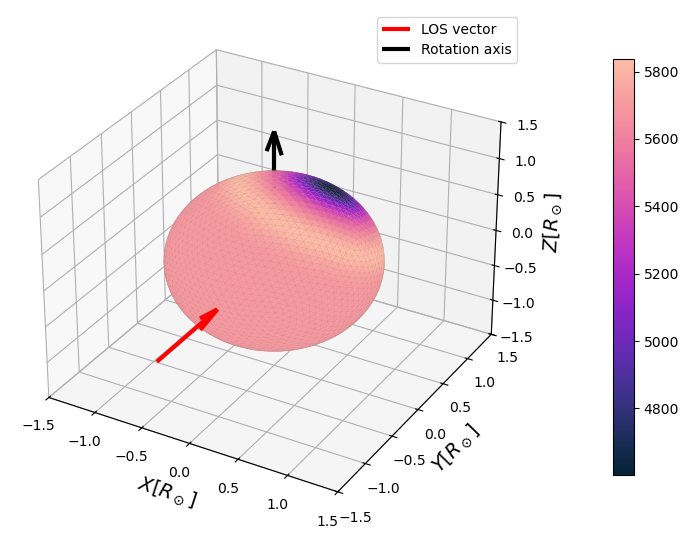

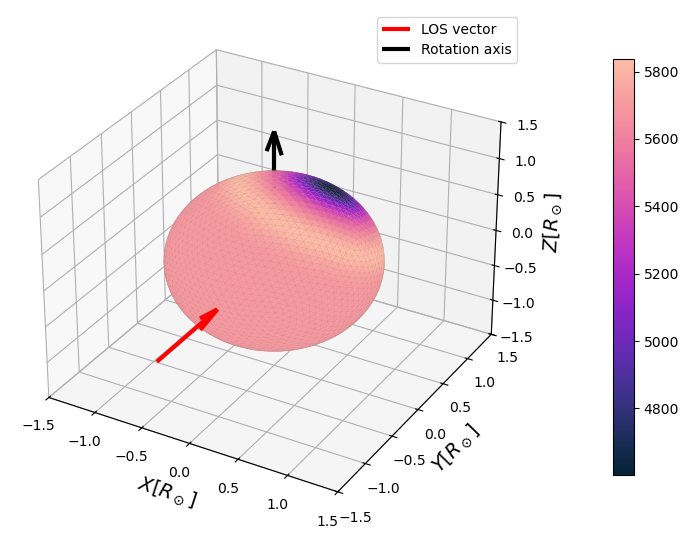

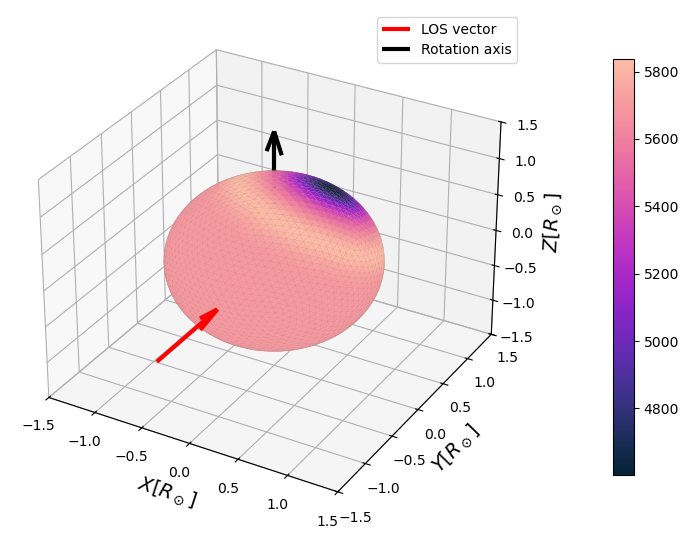

In [10]:
from spice.plots.plot_mesh import plot_3D


plot_3D(spotted_mesh, property=0)

In [14]:
from spice.models.mesh_transform import add_rotation, evaluate_rotation

rot_kms = 10.0  # rotational velocity in km/s
R_sun_km = 6.957e5  # solar radius in km
radius = spotted_mesh.radius * R_sun_km  # radius in km (assuming spotted_mesh.radius is in solar radii)
period_sec = 2 * np.pi * radius / rot_kms  # Period in seconds
period_days = period_sec / (3600 * 24)  # Period in days
print(f"Rotation period for v={rot_kms} km/s: {period_days:.2f} days")

m_rot = add_rotation(spotted_mesh, rot_kms)

Rotation period for v=10.0 km/s: 5.06 days


In [ ]:
times = jnp.linspace(0.0, period_sec, 100)
m_r_ev = [evaluate_rotation(m_rot, t) for t in times]